In [ ]:
%pip install arch
%pip install phat-tails
%pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import arch
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
import pandas_datareader.data as web
import math
import phat as ph
import tensorflow as tf
import scipy.stats as scist


In [2]:
spy_data = pd.read_csv('spy_historical.csv')
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
spy_data.set_index("Date", inplace = True)
spy_returns = (spy_data['Adj Close'].pct_change().dropna())*100
train_data = spy_returns['1996':'2013']
forecast_data = spy_returns['2014':'2024']

In [3]:

gm = arch_model(spy_returns, vol='garch', p=1,q=1, dist='normal')
res = gm.fit(last_obs = '2013-12-31',disp ='off')
forecast_pred_g = res.forecast(start='2014-01-01', horizon=1, method = 'simulation')
forecast_pred_garch = forecast_pred_g.variance.loc['2014-01-01':'2024-01-01']
forecast_data = forecast_data.loc['2014-01-01':'2024-01-01']

In [4]:
gm = arch_model(spy_returns, vol='aparch', p=1,q=1,o=1, dist ='ged')
res = gm.fit(last_obs = '2013-12-31',disp ='off')
xi_left, xi_right = ph.two_tailed_hill_double_bootstrap(train_data)
model = ph.Phat.fit(train_data, xi_left, xi_right)
phat = ph.Phat(model.params[0],model.params[1],xi_left,xi_right)


def custom_rng(phat):
    def _rng(size):
        shocks = phat.rvs(size=size)
        return shocks
    return _rng

sim= res.forecast(
    start='2014-01-01',
    horizon=1,
    simulations=10000,
    rng=custom_rng(phat),
    method='simulation',
    reindex=False
)


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 1.614420
         Iterations: 42
         Function evaluations: 77


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


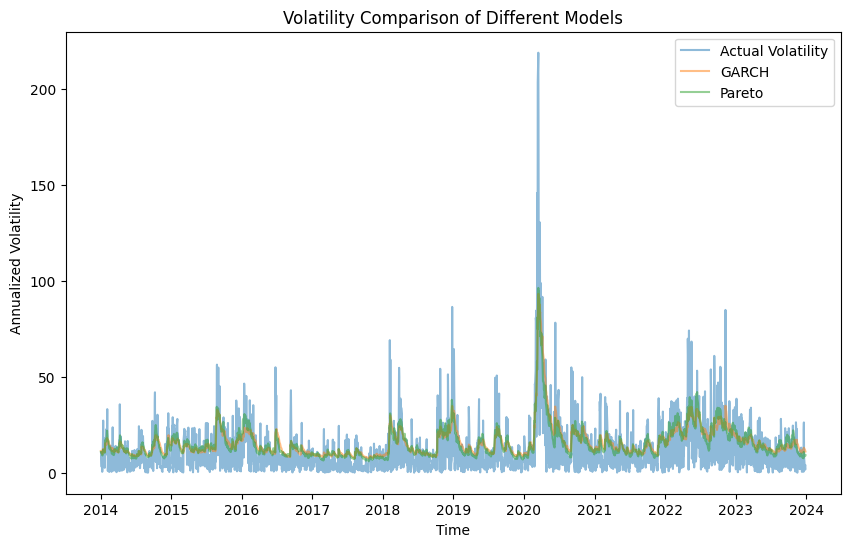

In [5]:
plt.figure(figsize=(10, 6))

alpha_ = 0.5

plt.plot(forecast_data.index,forecast_data.rolling(2).std()*np.sqrt(252) , label='Actual Volatility',alpha = alpha_)
plt.plot(forecast_data.index, np.sqrt(252) * np.sqrt(forecast_pred_garch['h.1']), label = 'GARCH' , alpha = alpha_)
plt.plot(forecast_data.index, np.sqrt(252) * np.sqrt(sim.variance.loc['2014-01-01':'2024-01-01']['h.1']), label = 'Pareto' , alpha = alpha_)
plt.legend()
plt.ylabel('Annualized Volatility')
plt.xlabel('Time')
plt.title('Volatility Comparison of Different Models')
plt.show()


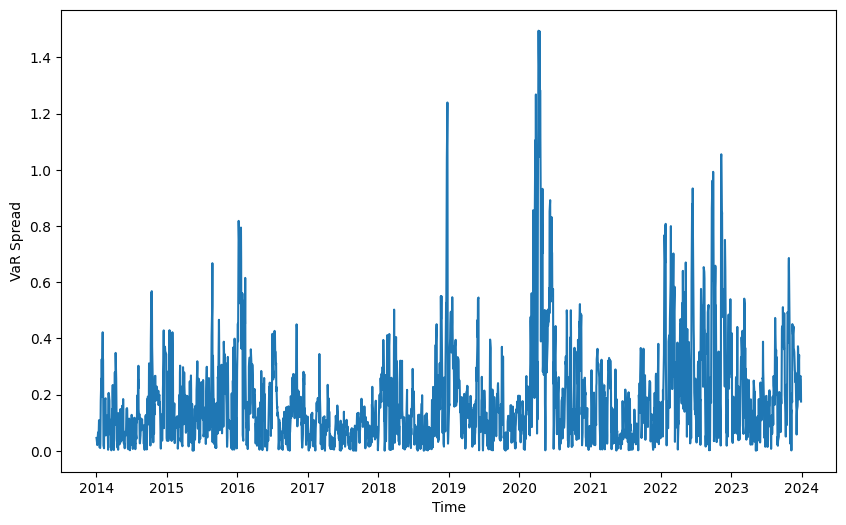

In [6]:
VaR_normal=forecast_pred_g.mean.loc['2014-01-01':'2024-01-01']-norm.ppf(0.95)*np.sqrt(forecast_pred_g.variance.loc['2014-01-01':'2024-01-01'])
VaR_tail=sim.mean.loc['2014-01-01':'2024-01-01']-norm.ppf(0.95)*np.sqrt(sim.variance.loc['2014-01-01':'2024-01-01'])
VaR_diff=np.abs(VaR_tail-VaR_normal)

plt.figure(figsize=(10, 6))
plt.plot(forecast_data.index, VaR_diff)
plt.ylabel('VaR Spread')
plt.xlabel('Time')
plt.show()


In [7]:
def d1(S,t,K,r,sig,T):
    return (math.log((S/K))+(r+0.5*sig*sig)*(T-t))/(sig*math.sqrt(T-t))
def d2(S,t,K,r,sig,T):
    return (math.log((S/K))+(r-0.5*sig*sig)*(T-t))/(sig*math.sqrt(T-t))
def bsput(S,t,K,r,sig,T):
    return K*math.exp(-r*(T-t))*norm.cdf(-1*d2(S,t,K,r,sig,T))-S*norm.cdf(-1*d1(S,t,K,r,sig,T))
def putpayoff(S,K):
    if(S>=K):
        return 0.0
    else:
        return (K-S)

In [8]:

spy = pd.read_csv('spy (1).csv')
spy['Date'] = pd.to_datetime(spy['Date'])
spy.set_index("Date", inplace = True)

gold = pd.read_csv('gold (1).csv')
gold['Date'] = pd.to_datetime(gold['Date'])
gold.set_index("Date", inplace = True)

tbill = pd.read_csv('tbill (1).csv')
tbill['Date'] = pd.to_datetime(tbill['Date'])
tbill.set_index("Date", inplace = True)
tbill = tbill.reindex(forecast_data.index, fill_value=0.0)
tbill= tbill.interpolate(method='linear', limit_area='inside')



dbc = pd.read_csv('dbc (1).csv')
dbc['Date'] = pd.to_datetime(dbc['Date'])
dbc.set_index("Date", inplace = True)

real_estate = pd.read_csv('vnq (1).csv')
real_estate['Date'] = pd.to_datetime(real_estate['Date'])
real_estate.set_index("Date", inplace = True)

tlt = pd.read_csv('tlt (1).csv')
tlt['Date'] = pd.to_datetime(tlt['Date'])
tlt.set_index("Date", inplace = True)

iei = pd.read_csv('iei (1).csv')
iei['Date'] = pd.to_datetime(iei['Date'])
iei.set_index("Date", inplace = True)

QQQ = pd.read_csv('qqq (1).csv')
QQQ['Date'] = pd.to_datetime(QQQ['Date'])
QQQ.set_index("Date", inplace = True)

DIA = pd.read_csv('dia (1).csv')
DIA['Date'] = pd.to_datetime(DIA['Date'])
DIA.set_index("Date", inplace = True)

vix = pd.read_csv('vix (1).csv')
vix['Date'] = pd.to_datetime(vix['Date'])
vix.set_index("Date", inplace = True)


weather_ret=(0.075*dbc['Adj Close'].shift(1).pct_change()+0.4*tlt['Adj Close'].shift(1).pct_change()
+0.3*spy['Adj Close'].shift(1).pct_change()+0.15*iei['Adj Close'].shift(1).pct_change()
+0.075*gold['Adj Close'].shift(1).pct_change())+1
spy_ret=spy['Adj Close'].shift(1).pct_change()+1
gold_ret=gold['Adj Close'].shift(1).pct_change()+1

In [9]:
strike=0.90*spy['Adj Close'].shift(1)
df=pd.DataFrame({'Date':forecast_data.index,'spy_ret': spy_ret.values,
                        'Regime': [2 if spread>=1.4 else 1 if spread>=0.8 else 0 for spread in VaR_diff['h.1'] ],
                       'gold_ret':gold_ret,
                    'weather_ret':weather_ret.values,
                         'rate':tbill['Adj Close'].shift(1).values,'spy':spy['Adj Close']*100,'vol': vix['Adj Close'].shift(1),
                 'Strike':strike})
df=df.dropna()
df['strat']=1
df['weather']=df['weather_ret']
df['commodities_ret']=dbc['Adj Close'].shift(1).pct_change()+1
df['real_estate_ret']=real_estate['Adj Close'].shift(1).pct_change()+1
df['qqq_ret']=QQQ['Adj Close'].shift(1).pct_change()+1
df['dia_ret']=DIA['Adj Close'].shift(1).pct_change()+1
num_index = pd.Index(range(0,len(df),1))
df.set_index(num_index,inplace=True)

In [10]:
protective_put=False
for i in range(0,len(df)):
    if(protective_put==True):
      if((df.loc[i,'Date']-option_start_date).days>=90):
        protective_put=False
        if(putpayoff(df.loc[i,'spy']/100,option_strike)>0.0):
          df.loc[i,'strat']=(option_strike*100)/option_start_underlying
      else:
        df.loc[i,'strat']=df.loc[i,'spy_ret']
    elif(df.loc[i,'Regime']==2):
      protective_put=True
      option_price=bsput(df['spy'][i]/100,0,df['Strike'][i],df['rate'][i]/100,df['vol'][i]/100,90/365)*100
      option_strike=df['Strike'][i]
      option_txn_cost=0.65
      option_price+=option_txn_cost
      option_start_date=df['Date'][i]
      df.loc[i,'spy']-=option_price
      option_start_underlying=df.loc[i,'spy']
      df.loc[i,'strat']=(df.loc[i,'spy']/df.loc[i-1,'spy'])

    elif(df.loc[i,'Regime']==0):
        df.loc[i,'strat']=df.loc[i,'spy_ret']
    elif(df.loc[i,'Regime']==1):
        df.loc[i,'strat']=df.loc[i,'weather_ret']


In [11]:
def maxDD(strat):
  cum_ret=strat.cumprod()
  cum_max=cum_ret.cummax()
  dd=(cum_ret-cum_max)/cum_max
  return min(dd[1:])

def metrics(strat):
  Mean_strat=np.log(strat).mean()*(252)
  STD_strat=np.log(strat).std()*math.sqrt(252)
  CAGR_strat=math.log(strat.cumprod()[len(df)-1])/10
  Sharpe_strat = (Mean_strat-0.005)/STD_strat
  lr=np.log(strat)
  DD_strat=(lr[lr<0]).std()*math.sqrt(252)
  return {'CAGR':CAGR_strat,'Sharpe':Sharpe_strat,'Sortino':(Mean_strat-0.005)/DD_strat,'MaxDD':maxDD(strat)}

def plot_backtest(strat1,strat2,label1,label2):
  x = df['Date']
  fig, ax = plt.subplots()
  ax.plot(x, strat1.cumprod(), label=label1)
  ax.plot(x, strat2.cumprod(), label=label2)
  dict_metrics_strat1 = metrics(strat1)
  dict_metrics_strat2 = metrics(strat2)
  str_ = label1 +'\n'
  for key in dict_metrics_strat1.keys():
    str_ += key + " : " + str(dict_metrics_strat1[key]) + '\n'

  bbox = dict(boxstyle='round', facecolor='white', alpha=0.7)
  ax.text(0.32, 0.76, s=str_, ha='center', va='center', bbox=bbox, transform=fig.transFigure)
  str_ = label2 + '\n'
  for key in dict_metrics_strat2.keys():
    str_ += key + " : " + str(dict_metrics_strat2[key]) + '\n'
  ax.text(0.32, 0.52, s=str_, ha='center', va='center', bbox=bbox, transform=fig.transFigure)

  plt.title('Comparison of the two strategies')
  plt.legend(loc='lower right')
  plt.show()


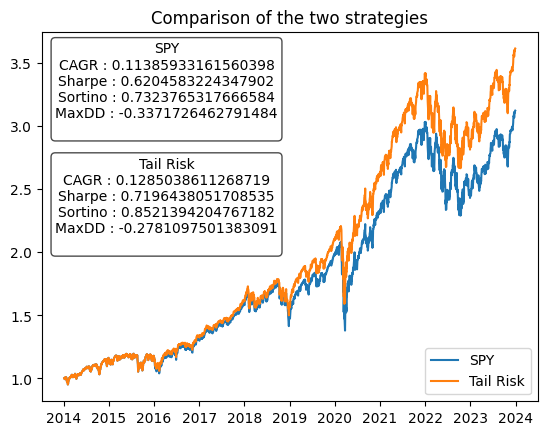

In [12]:
plot_backtest(df['spy_ret'],df['strat'],'SPY','Tail Risk')

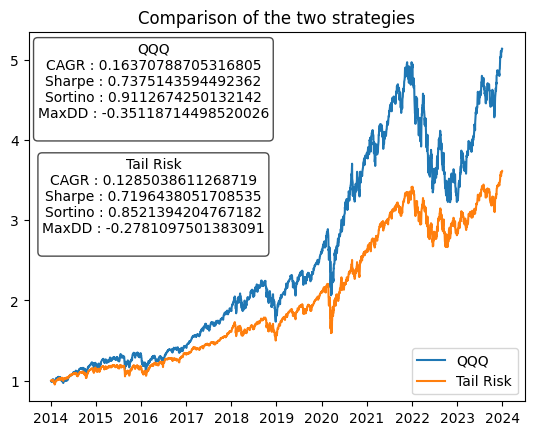

In [13]:
plot_backtest(df['qqq_ret'],df['strat'],'QQQ','Tail Risk')

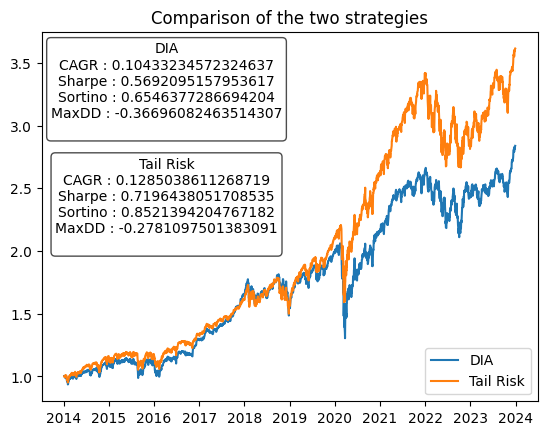

In [14]:
plot_backtest(df['dia_ret'],df['strat'],'DIA','Tail Risk')

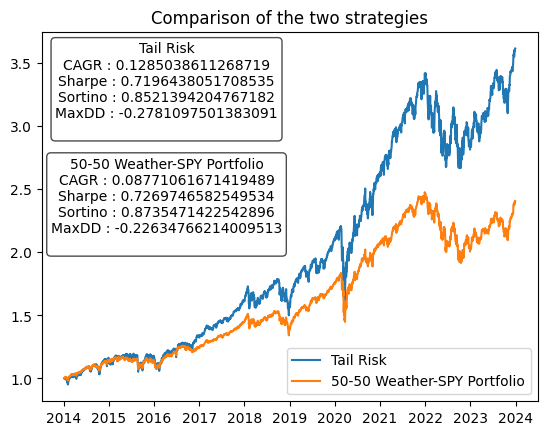

In [15]:
plot_backtest(df['strat'],(df['weather']+df['spy_ret'])/2,'Tail Risk','50-50 Weather-SPY Portfolio')

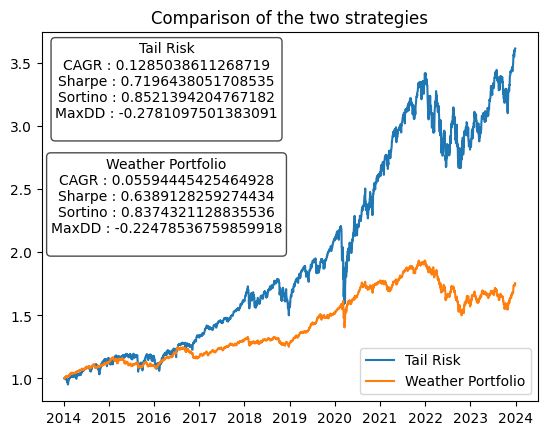

In [16]:
plot_backtest(df['strat'],df['weather'],'Tail Risk','Weather Portfolio')

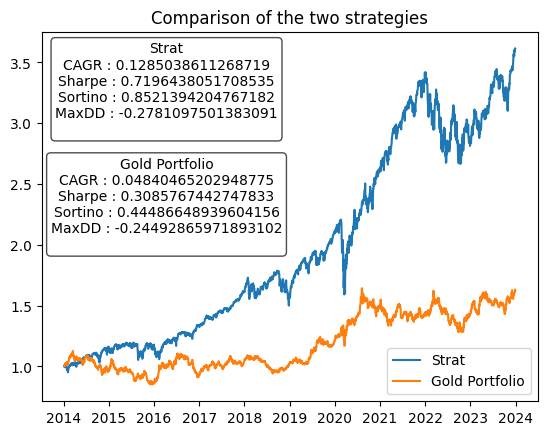

In [17]:
plot_backtest(df['strat'],df['gold_ret'],'Strat','Gold Portfolio')

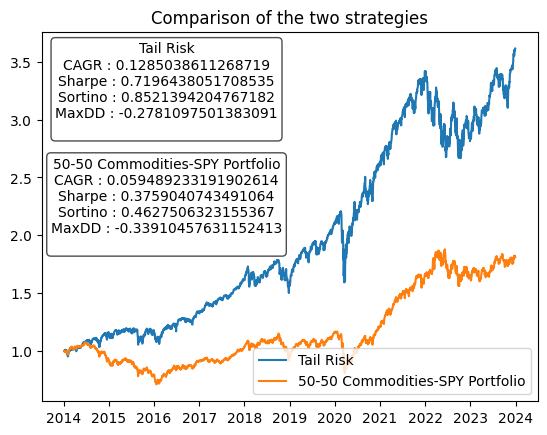

In [18]:
plot_backtest(df['strat'],(df['commodities_ret']+df['spy_ret'])/2,'Tail Risk','50-50 Commodities-SPY Portfolio')

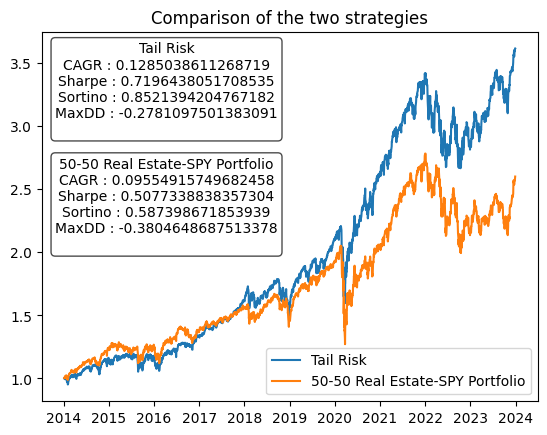

In [19]:
plot_backtest(df['strat'],(df['real_estate_ret']+df['spy_ret'])/2,'Tail Risk','50-50 Real Estate-SPY Portfolio')

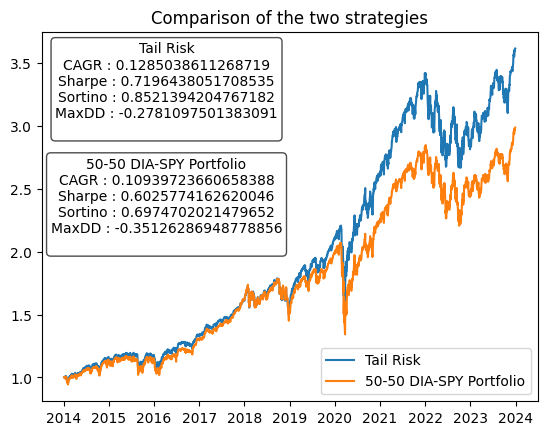

In [20]:
plot_backtest(df['strat'],(df['dia_ret']+df['spy_ret'])/2,'Tail Risk','50-50 DIA-SPY Portfolio')

In [21]:
strike=0.90*spy['Adj Close'].shift(1)
options= pd.DataFrame({'Date':forecast_data.index,'vol': vix['Adj Close'].shift(1),
                        'rate': tbill['Adj Close'].shift(1)
                       ,'spy':spy['Adj Close'].shift(1)*100,'Strike':strike})
options=options.dropna()
num_index = pd.Index(range(0,len(options),1))
options.set_index(num_index,inplace=True)
option_price=bsput(options['spy'][0]/100,0,options['Strike'][0],options['rate'][0]/100,options['vol'][0]/100,90/365)*100
option_strike=options['Strike'][0]
option_txn_cost=0.65
option_price+=option_txn_cost
option_start_date=options['Date'][0]
options.loc[0,'spy']-=option_price
option_start_underlying=options.loc[0,'spy']
option_daily_price=option_price/90
payoff=False
for i in range(0,len(options)):
  if((options.loc[i,'Date']-option_start_date).days>=90):
    if(putpayoff(options.loc[i,'spy']/100,option_strike)>0.0):
          options.loc[i,'spy']=option_strike*100
          option_start_underlying=options.loc[i,'spy']
          option_price=bsput(options['spy'][i]/100,0,options['Strike'][i],options['rate'][i]/100,options['vol'][i]/100,90/365)*100
          option_strike=options['Strike'][i]
          option_txn_cost=0.65
          option_price+=option_txn_cost
          option_start_date=options['Date'][i]
          options.loc[i,'spy']-=option_price
    else:
      option_price=bsput(options['spy'][i]/100,0,options['Strike'][i],options['rate'][i]/100,options['vol'][i]/100,90/365)*100
      option_strike=options['Strike'][i]
      option_txn_cost=0.65
      option_price+=option_txn_cost
      option_start_date=options['Date'][i]
      options.loc[i,'spy']-=option_price
      options.loc[i,'spy']=option_start_underlying
  else:
    options.loc[i,'spy']=option_start_underlying
options['pp_ret']=options['spy'].pct_change()+1
options=options.dropna()


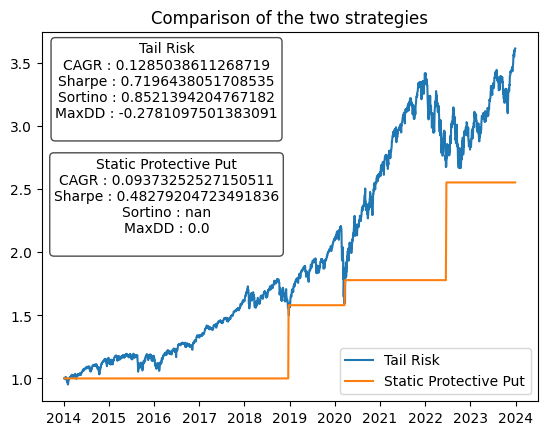

In [22]:
plot_backtest(df['strat'],options['pp_ret'],'Tail Risk','Static Protective Put')